### This notebook shows how to open a Matlab file containing data for an example simulation (details of the set-up provided below) and plot some relevant outputs (velocity and pressure fields, cross-shore energy flux, modal decomposition of the cross-shore energy flux at the off-shore boundary).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat

Open Matfile using loadmat module and extract all the data from the loaded dictionary.

In [2]:
set_up_data = loadmat('../data/example_data_600_200.mat')

In [3]:
#SET-UP VARIABLES
L = set_up_data['L'] #domain size (m): size[1,]
Nx = set_up_data['Nx'] #number of grid points in x: size[1,]
Nz = set_up_data['Nz'] #number of grid points in z: size[1,]
R = set_up_data['R'] #surface boundary condition (=0: rigid lid, =1: free surface): size[1,]
f = set_up_data['f'] #Coriolis parameter (1/s): size[1,]
W = set_up_data['W'] #slope width (m): size[1,]
xs = set_up_data['xs'] #shelf width (m): size[1,]
g = set_up_data['g'] #gravity (m/s^2): size[1,]
h0 = set_up_data['h0'] #ocean depth (m): size[1,]
hc= set_up_data['hc'] #depth at the coast (m): size[1,]
hs= set_up_data['hs'] #depth at the shelf break (m): size[1,]
Zpyc= set_up_data['Zpyc'] #pycnocline depth (m): size[1,] --> negative value
mupyc= set_up_data['mupyc'] #pycnocline width (m): size[1,]
xx = set_up_data['xx'] #grid in x
z = set_up_data['z'] #grid in z
force_type = set_up_data['force_type'] #force type (=0: Baines body force, =1: isolated forcing): size[1,]

In [4]:
#PRODUCED VARIABLES
h = set_up_data['h'] #topographic depth (m): size[Nx,Nz]
hx = set_up_data['hx'] #topographic slope (dh/dx): size[Nx,Nz]
N2 = set_up_data['N2'] #stratification (1/s^2): size[Nx,Nz]
F = set_up_data['F']  #forcing across the domain (see force_type): size[Nx,Nz]
up = set_up_data['fu'] #cross-shore energy flux <up> (W/m^2): size[Nx,Nz]
vp = set_up_data['fv'] #along-shore energy flux <vp> (W/m^2): size[Nx,Nz]
up_x = set_up_data['XFlux'] #vertically integrated cross-shore energy flux <up> (W/m): size[Nx,]
vp_x = set_up_data['AFlux'] #vertically integrated along-shore energy flux <vp> (W/m): size[Nx,]
u = set_up_data['uModeF'] #cross-shore velocity (vertical average removed) (m/s): size[Nx,Nz]
v = set_up_data['vModeF'] #along-shore velocity (vertical average removed) (m/s): size[Nx,Nz]
p = set_up_data['pModeF'] #pressure (vertical average removed) (m^2/s^2): size[Nx,Nz]
up_modal_offshore = set_up_data['up_modal_offshore'] #cross-shore energy flux <up> (W/m^2) in each vertical mode 
            #at the off-shore (deep ocean) boundary: size[Nz-1,Nz]
up_modal_integrated = set_up_data['up_modal_integrated'] #vertically-integrated cross-shore energy flux <up> (W/m) 
            #in each vertical mode at the off-shore (deep ocean) boundary: size[Nz-1,]
up_modal_all = set_up_data['up_modal_all'] #vertically-integrated cross-shore energy flux <up> (W/m) 
            #in each vertical mode at the off-shore (deep ocean) boundary
            #including cross-mode terms <u_i p_j> for i \neq j: size[Nz-1,]

**We will plot the set-up of this problem first. Color will indicate stratification $N^2\, (s^{-2})$ The specifications are as follows:** 
- **topography parameters:** shelf width $x_s=80$km, slope width $W=32$km, domain width $L=800$km, deep ocean depth $h_0=3100$m, depth at the coast $h_c=100$m, depth at the shelf break $h_s=150$m;
- **stratification parameters:** pycnocline depth $Z_{pyc}=600$m, pycnocline width $\mu_{pyc}=200$m.

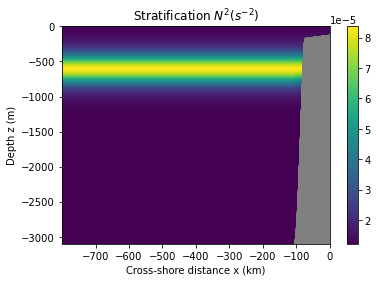

In [5]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(xx/1e3,z,N2,shading='gouraud')
fig.colorbar(im, ax=ax0)
ax0.set_facecolor('gray')
ax0.set_title('Stratification $N^2 (s^{-2})$')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Depth z (m)');

We also can plot the body force - in this example, we applied Baines body force, which represents the vertical displacement of isopycnals by the barotropic tide (see manuscript for details), in the pressure equation. Because Baines body force is a function of topographic slope, it is zero in most of the domain, except it is maximized near the shelf break. We zoomed in on the relevant part of the domain. It is also important to note that these calculations were done on a staggered grid for a coupled  𝑢−𝑝  system, so  𝑢  is solved on even  𝑥 -grid points and  𝑝  on odd  𝑥 -grid points. Therefore, plotting of the forcing on pressure is done on the every other point in  𝑥  for the cross-shore distance and depth matrices, xx and z, respectively. Forcing at other $x$-grid points (on $u$) is zero.

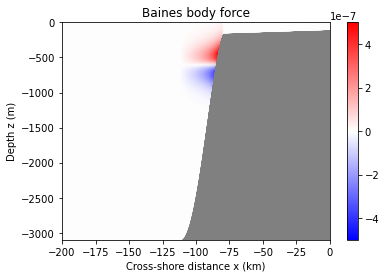

In [7]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(xx[:,0:-1:2]/1e3,z[:,0:-1:2],F[:,0:-1:2],shading='gouraud',
                   cmap=plt.get_cmap('bwr'),vmin=-5e-7, vmax=5e-7)
fig.colorbar(im, ax=ax0)
ax0.set_facecolor('gray')
ax0.set_title('Baines body force')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Depth z (m)');
ax0.set_xlim([-200,0]);

Velocity (cross-shore and along-shore) and pressure all have both real and imaginary components, but for illustration, we will only plot the real parts of the cross-shore velocity and pressure. It is also important to note that these calculations were done on a staggered grid for a coupled $u-p$ system, so $u$ is solved on even $x$-grid points and $p$ on odd $x$-grid points. We then interpolated $u$ only the odd grid points. Therefore, plotting is done on the every other point in $x$ for the cross-shore distance and depth matrices, xx and z, respectively.

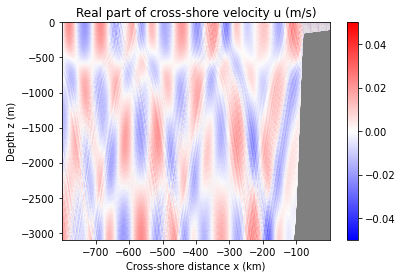

In [8]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(xx[:,0:-1:2]/1e3,z[:,0:-1:2],np.real(u),shading='gouraud',
                   cmap=plt.get_cmap('bwr'),vmin=-0.05, vmax=0.05)
fig.colorbar(im, ax=ax0)
ax0.set_facecolor('gray')
ax0.set_title('Real part of cross-shore velocity u (m/s)')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Depth z (m)');

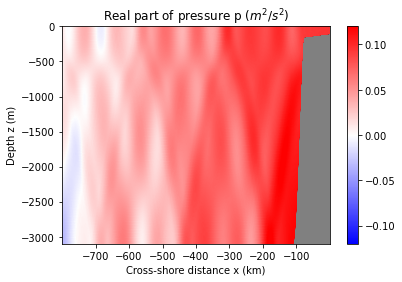

In [9]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(xx[:,0:-1:2]/1e3,z[:,0:-1:2],np.real(p),shading='gouraud',
                   cmap=plt.get_cmap('bwr'),vmin=-0.12, vmax=0.12)
fig.colorbar(im, ax=ax0)
ax0.set_facecolor('gray')
ax0.set_title('Real part of pressure p $(m^2/s^2)$')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Depth z (m)');

Cross-shore energy flux is computed as $0.5(Re(u) Re(p) + Im(u) Im(p))$, where $Re$ and $Im$ represent real and imaginary parts of cross-shore velocity and pressure.

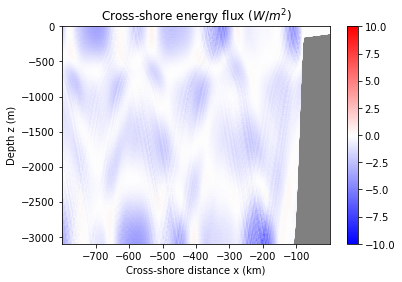

In [10]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(xx[:,0:-1:2]/1e3,z[:,0:-1:2],up,shading='gouraud',
                   cmap=plt.get_cmap('bwr'),vmin=-10, vmax=10)
fig.colorbar(im, ax=ax0)
ax0.set_facecolor('gray')
ax0.set_title('Cross-shore energy flux $(W/m^2)$')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Depth z (m)');

We will plot vertically-integrated cross-shore energy flux, which is the values from the previous figure vertically integrated at each cross-shore location.

(-800.0, 0.0)

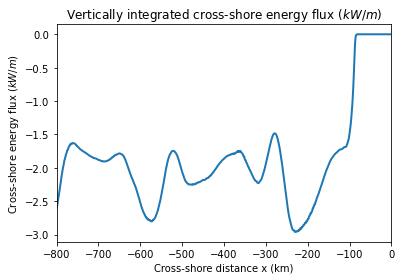

In [11]:
fig, ax0 = plt.subplots()
ax0.plot(xx[0,0:-1:2]/1e3,up_x.reshape(up_x.shape[1],)/1e3,linewidth=2)
ax0.set_title('Vertically integrated cross-shore energy flux $(kW/m)$')
ax0.set_xlabel('Cross-shore distance x (km)')
ax0.set_ylabel('Cross-shore energy flux $(kW/m)$')
ax0.set_xlim([-800,0])

We will plot the amount of cross-shore energy in each vertical mode at the off-shore boundary, i.e., $u_i p_i$. Higher modes have very small contribution, so we only show the top $20$ modes. We compute the energy flux in each mode as: $0.5(Re(u_i) Re(p_i) + Im(u_i) Im(p_i)), where $Re$ is the real part and $Im$ is the imaginary part, and then integrate vertically. 

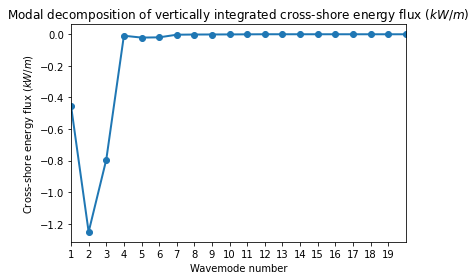

In [12]:
fig, ax0 = plt.subplots()
ax0.plot(range(1,up_modal_integrated.shape[1]+1),
         up_modal_integrated.reshape(up_modal_integrated.shape[1],)/1e3,'-o',linewidth=2)
ax0.set_title('Modal decomposition of vertically integrated cross-shore energy flux $(kW/m)$')
ax0.set_xlabel('Wavemode number')
ax0.set_ylabel('Cross-shore energy flux $(kW/m)$')
ax0.set_xlim([1, 20])
ax0.set_xticks(range(1,20));

Now we will plot modal decomposition of cross-shore energy flux (vertically integrated), computed as $u_i p_j$, where $i,j$ are wavemode numbers. We will consider both $i=j$ and $i\neq j$. In principle, all vertical modes at the off-shore (deep ocean) boundary should be orthogonal, so $u_i p_j=0$ for $i\neq j$. However, because of the numerical errors in computing eigenvalues and eigenvectors, in particular for non-uniform stratifications (see manuscript for details), there might be some contribution from these cross-modal terms. Here, we see that most of the cross-shore energy falls on the $i=j$ diagonal (as expected from orthogonal modes), however, there are very small contributions from $i\neq j$ because of the numerical errors. It is important to make sure that the resolution of the simulation is enough to keep these deviations from orthogonality small.

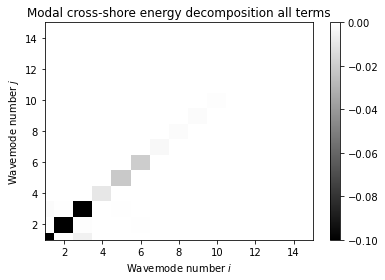

In [13]:
fig, ax0 = plt.subplots()
im = ax0.pcolormesh(range(1,up_modal_integrated.shape[1]+1),
                    range(1,up_modal_integrated.shape[1]+1),
                    up_modal_all/1e3,shading='auto',
                   cmap=plt.get_cmap('gray'),
                   vmin=-0.1, vmax=0)
fig.colorbar(im, ax=ax0)
ax0.set_xlim((1,15));
ax0.set_ylim((1,15));
ax0.set_xlabel('Wavemode number $i$');
ax0.set_ylabel('Wavemode number $j$');
ax0.set_title('Modal cross-shore energy decomposition all terms');